In [1]:
%config Completer.use_jedi = False

# What is tesspy?


tesspy is a python library for geographical tessellation. By discretizing urban areas,
it builds local geographical units that allow further quantitative analysis. 
There is no gap or overlap between these geographical units.
In addition to regular tessellation methods, such as square grid and hexagon grid, it builds irregular
tessellations, such as voronoi diagrams and city blocks, based on OpenStreetMap geospatial data.



# Dependencies

tesspy's Dependencies are: `geopandas`,`h3`,`osmnx`,`hdbscan`,`mercantile`,`overpass`.



# Installation

You can install ``tesspy`` from PyPI using pip:
```
pip install tesspy
```

# Creating a new environment for tesspy

tesspy depends on `geopandas`, which could make the installation sometimes tricky because of the conflicts with the current packages. Therefore, we recommend creating a new clean environment and installing the dependencies from the conda-forge channel.


Create a new environment:
```shell
conda create -n tesspy_env -c conda-forge
```

Activate this environment:
```shell
conda activate tesspy_env
```

Install dependencies from conda-forge channel:
```shell
conda install -c conda-forge geopandas h3-py osmnx hdbscan mercantile -y
```

Install tesspy:
```shell
pip install tesspy
```

# Example: Tessellation of Frankfurt am Main

This example shows the basic functions of `tesspy`, which are five types of tessellations: square, hexagon, adaptive squares, voronoi diagrams and city blocks. We have selected the city of **Frankfurt am Main** in Germany to demonstrate tessellation.


### Import Tessellation

We start by importing the `Tessellation` object from `tesspy` module:

In [2]:
from tessellation import Tessellation

In [3]:
# import warnings
# warnings.simplefilter("ignore")

### Defining the area

There are different ways to define the area. The most straightforward way is passing an address.

In [4]:
ffm= Tessellation('Frankfurt am Main')

With `.get_polygone()` method, we can retrieve the polygon. This is in the form of a GeoPandas GeoDataFrame. We visualize the polygon to make sure data collection was successful and correct:

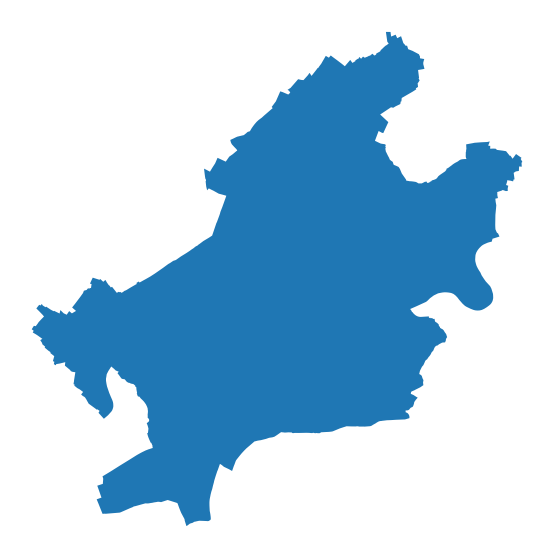

In [5]:
ffm.get_polygon().plot(figsize=(10,10)).set_axis_off();

The polygon shows the city of Frankfurt. Note that the `CRS` of the GeoPandas is `EPSG:4326`. We can double-check that:

In [6]:
print(ffm.get_polygon().crs)

epsg:4326


It is already ready for tessellation.

### Squares
The first tessellation method is the square grid. It creates (almost) equal squares that cover the whole area surface. In order to set the size, we need to pass a `resolution`. 
This value is usually between 1 and 21. Larger values mean smaller squares and consequently a finer tessellation.
For example, with a `resolution=13`, we have:

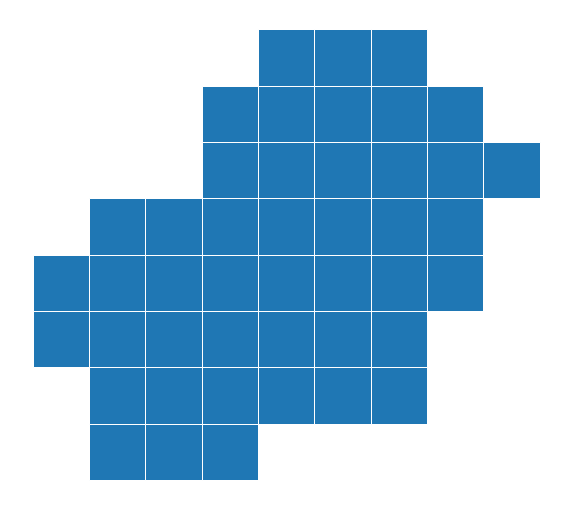

In [7]:
ffm_sqr_13=ffm.squares(13)
ffm_sqr_13.plot(lw=1, edgecolor='w', figsize=(10,10)).set_axis_off();

In [8]:
ffm_sqr_13.head()

,geometry,quadkey
0,"POLYGON ((8.48145 50.09239, 8.48145 50.12058, ...",1202033020220
1,"POLYGON ((8.48145 50.06419, 8.48145 50.09239, ...",1202033020222
2,"POLYGON ((8.52539 50.12058, 8.52539 50.14875, ...",1202033020203
3,"POLYGON ((8.52539 50.09239, 8.52539 50.12058, ...",1202033020221
4,"POLYGON ((8.52539 50.06419, 8.52539 50.09239, ...",1202033020223


The square grid with a `resolution=15` look like this:

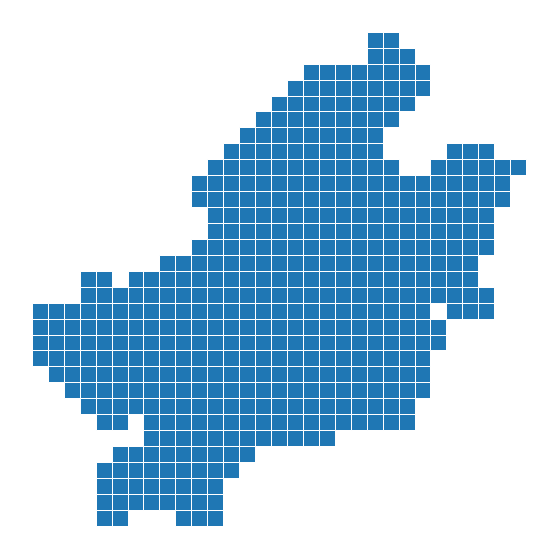

In [9]:
ffm_sqr_15=ffm.squares(15)
ffm_sqr_15.plot(lw=1, edgecolor='w',figsize=(10,10)).set_axis_off();

As it can be seen the number of square are relatively higher when resolution is higher. We can check the number of squares for each resolution:

In [10]:
print('Resolution=13  ==>  Number of squares:  ', ffm_sqr_13.shape[0])
print('Resolution=15  ==>  Number of squares:  ', ffm_sqr_15.shape[0])

Resolution=13  ==>  Number of squares:   45
Resolution=15  ==>  Number of squares:   488


### hexagons

The next method is hexagons. Similar to squares, this method creates (almost) equal shapes to cover the area. A slight difference is that the algorithm finds the optimal number of hexagons, and not all the surface is covered. Therefore, there may be some areas on the borders which are left behind.

Similarly, we need to pass a resolution to set the hexagon sizes. The larger numbers mean smaller hexagons. A suitable value is usually between 5 and 15.
Here is the hexagon tessellation with `resolution=7`:

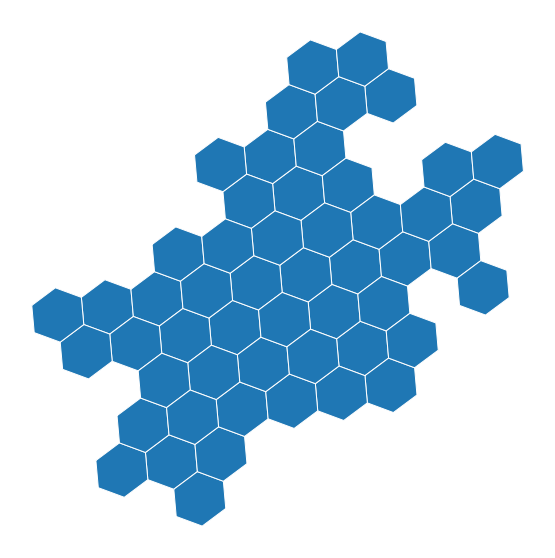

In [11]:
ffm_hex_7=ffm.hexagons(7)
ffm_hex_7.plot(lw=1, edgecolor='w',figsize=(10,10)).set_axis_off();

In [12]:
ffm_hex_7.head()

,hex_id,geometry
0,871faea1affffff,"POLYGON ((8.67662 50.13037, 8.67822 50.11868, ..."
1,871faeaa6ffffff,"POLYGON ((8.51031 50.11313, 8.51194 50.10145, ..."
2,871faea82ffffff,"POLYGON ((8.55326 50.04646, 8.55488 50.03477, ..."
3,871faeaf6ffffff,"POLYGON ((8.68141 50.09530, 8.68301 50.08361, ..."
4,871faeaaeffffff,"POLYGON ((8.59585 50.10425, 8.59746 50.09256, ..."


At the next resolution, in this case, `resolution=8`, each hexagon is divided into 7 sub-hexagons. This means the total number of hexagons is (almost) 7 times more when resolution increments one unit. Following plot shows the hexagons of Frankfurt with `resolution=8`:

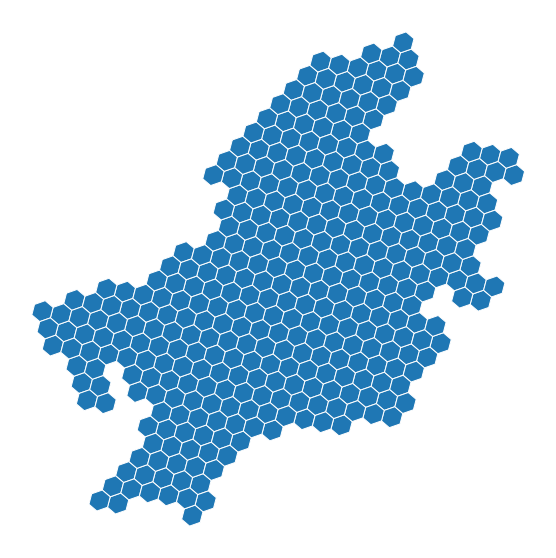

In [13]:
ffm_hex_8=ffm.hexagons(8)
ffm_hex_8.plot(lw=1, edgecolor='w',figsize=(10,10)).set_axis_off();

In [14]:
print('Resolution=7  ==>  Number of hexagons:  ', ffm_hex_7.shape[0])
print('Resolution=8  ==>  Number of hexagons:  ', ffm_hex_8.shape[0])

Resolution=7  ==>  Number of hexagons:   53
Resolution=8  ==>  Number of hexagons:   366


### Adaptive squares

Adaptive squares are an extension of regular squares. This method starts with relatively large squares and uses the spatial data, i.e., Points of Interests (POI), to divide the high-density squares into 4 subsquares. The division of squares is done until a specific threshold for POI count per square is reached.

The spatial data are retrieved from OpenStreetMap (OSM). We can use which POI categories we want to use. The selected POI categories should be passed as a list. These categories are the OSM primary categories, which represent physical objects on the map. More information can be found at this [link](https://wiki.openstreetmap.org/wiki/Map_features).

You can see the top-level categories by:

In [15]:
print(Tessellation.osm_primary_features())

['aerialway', 'aeroway', 'amenity', 'barrier', 'boundary', 'building', 'craft', 'emergency', 'geological', 'healthcare', 'highway', 'historic', 'landuse', 'leisure', 'man_made', 'military', 'natural', 'office', 'place', 'power', 'public_transport', 'railway', 'route', 'shop', 'sport', 'telecom', 'tourism', 'water', 'waterway']


So we build the adaptive squares for 

In [16]:
# Adaptive Squares using only amenity data
ffm_asq = ffm.adaptive_squares(start_resolution=13, 
                                 poi_categories=["amenity"], 
                                 threshold=None,
                                 verbose=True)

Getting data from OSM...
Creating POI DataFrame...
Cleaning POI DataFrame...
Threshold=198  ==> set as the median POI-count per square at the initial level
Threshold exceeded! Squares are subdivided into resolution 14
Threshold exceeded! Squares are subdivided into resolution 15
Threshold exceeded! Squares are subdivided into resolution 16
Threshold exceeded! Squares are subdivided into resolution 17


We visualize the adaptive squares:

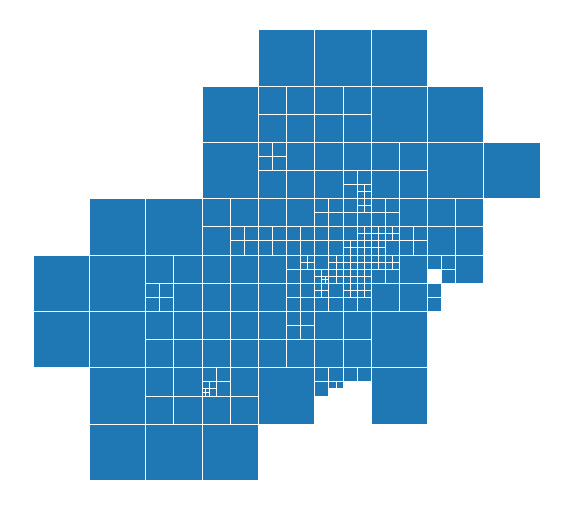

In [17]:
ffm_asq.plot(lw=1, edgecolor='w', figsize=(10,10)).set_axis_off();

In [19]:
ffm_asq.head()

,quadkey,count,geometry
0,1202033020033,83,"POLYGON ((8.61328 50.17690, 8.61328 50.20503, ..."
1,1202033020120,32,"POLYGON ((8.65723 50.20503, 8.65723 50.23315, ..."
2,1202033020121,39,"POLYGON ((8.70117 50.20503, 8.70117 50.23315, ..."
3,12020330201220,5,"POLYGON ((8.63525 50.19097, 8.63525 50.20503, ..."
4,12020330201221,49,"POLYGON ((8.65723 50.19097, 8.65723 50.20503, ..."


## Voronoi-Diagrams

Voronoi-Diagram is a method for tessellation that uses irregular shapes to cover the area. In this method, we have a given set of points, called generators. For each generator, there is a polygon that contains the area that is closer to this generator than other generators.

In this context, the generators are the POI, coming from OSM as explained for adaptive squares. Usually, the number of POI is larger than the required number of polygons. So, we can use a clustering method to cluster POI in the first step and then use the cluster centroids as the generator points.

In the example below, we use `shop` and `public_transport` as POI. We use the `k-means` clustering algorithm to cluster the POI and build the generators. The number of polygons is set to 100.

In [20]:
ffm_voronoi= ffm.voronoi(cluster_algo='k-means',
                        poi_categories=['shop','public_transport'],
                        timeout=60,
                        n_polygons=100,
                        verbose=True)

Getting data from OSM...
Creating POI DataFrame...
Cleaning POI DataFrame...
K-Means Clustering...
Creating Voronoi polygons...


We can now plot and visualize the voronoi polygons:

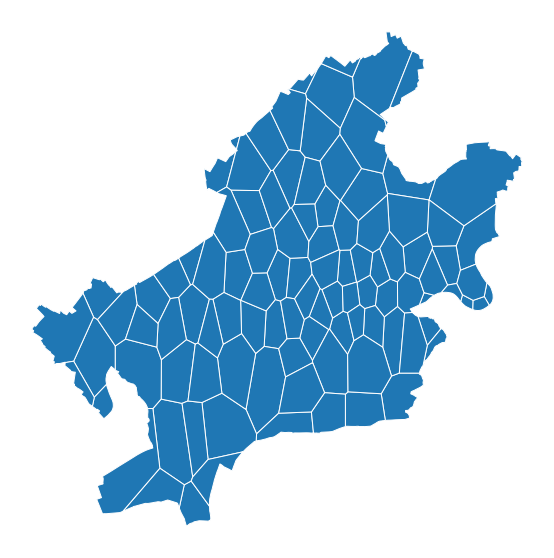

In [21]:
ffm_voronoi.plot(lw=1, edgecolor='w', figsize=(10,10)).set_axis_off();

In [22]:
ffm_voronoi.head()

,geometry
0,"POLYGON ((8.70617 50.07221, 8.71306 50.07981, ..."
1,"POLYGON ((8.58026 50.11904, 8.59145 50.11270, ..."
2,"POLYGON ((8.67856 50.13361, 8.68551 50.13379, ..."
3,"POLYGON ((8.75906 50.12506, 8.75623 50.13559, ..."
4,"POLYGON ((8.64520 50.15162, 8.63395 50.16790, ..."


In [23]:
print('Number of polygons ==> ' ,len(ffm_voronoi))

Number of polygons ==>  100


### City blocks
The last tessellation method is city blocks. We define city blocks as the smallest area surrounded by street segments. This method gets the road network data from OSM and generates polygons based on the roads. We use hierarchical clustering to merge a group of contiguous polygons. This guarantees that tiny polygons like road islands are not identified as single polygons. The number of desired polygons can be passed.

For example, the following is the example of city blocks for Frankfurt:

In [22]:
ffm_cb = ffm.city_blocks(number_of_LGUs=500,
                          detail_deg=None,
                          split_roads=True,
                          verbose=True)

Creating custom filter for all highway types
Created custom filter is ['highway'~'motorway|trunk|primary|secondary|tertiary|residential|unclassified|motorway_link|trunk_link|primary_link|secondary_link|living_street|pedestrian|track|bus_guideway|footway|path|service|cycleway']
Collection street network data
Splitting the linestring, such that each linestring has exactly 2 points.
Collected data has 272749 street segments
Road data is collected. Overall 272749 streets are included.
Creating initial city blocks using the road network data
Filtered out 6306 polygons, that where not in the area.


/home/siavash/ownCloud/gf-relut-data/Datenanalyse/40 ClusterMobil/30 Cluster Mobil Package Project/tesspy/tessellation_functions.py:339: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  merged_polygons = gpd.GeoSeries(cascaded_union(blocks["geometry"].values))
TopologyException: side location conflict at 8.5697030448103764 50.05096831650188. This can occur if the input geometry is invalid.


ValueError: No Shapely geometry can be created from null value

In [ ]:
ffm_cb.plot(lw=1, edgecolor='w', figsize=(10,10)).set_axis_off();

In [ ]:
ffm_cb.head()

In [ ]:
print('Number of polygons ==> ' ,len(ffm_cb))